In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import dash
from dash import dcc, html, Input, Output
import plotly.io as pio

# ========== Parameters ==========
sampling_rate = 500
segment_duration = 10
samples_per_segment = sampling_rate * segment_duration

# ========== File Loading ==========
df_lat = pd.read_csv("GPS.latitude.csv", header=None)
df_lon = pd.read_csv("GPS.longitude.csv", header=None)
df_speed = pd.read_csv("GPS.speed.csv", header=None)
df_ch1 = pd.read_csv("CH1_ACCEL1Z1.csv", header=None)
df_ch2 = pd.read_csv("CH2_ACCEL1Z2.csv", header=None)

# ========== Timestamp ==========
num_samples = len(df_ch1)
timestamps = np.arange(num_samples) / sampling_rate

# ========== Vibration Segments ==========
segments = []
for i in range(0, num_samples, samples_per_segment):
    if i + samples_per_segment <= num_samples:
        segments.append({
            "timestamp": timestamps[i:i + samples_per_segment],
            "ch1": df_ch1.iloc[i:i + samples_per_segment, 0].reset_index(drop=True),
            "ch2": df_ch2.iloc[i:i + samples_per_segment, 0].reset_index(drop=True),
        })

# ========== GPS Data ==========
min_len = min(len(df_lat), len(df_lon), len(df_speed))
gps_df = pd.DataFrame({
    "lat": df_lat.iloc[:min_len, 0],
    "lon": df_lon.iloc[:min_len, 0],
    "speed": df_speed.iloc[:min_len, 0]
})

# ========== Save Static GPS Image ==========
map_fig = go.Figure(go.Scattermapbox(
    lat=gps_df["lat"],
    lon=gps_df["lon"],
    mode="markers+lines",
    marker=dict(size=6, color=gps_df["speed"], colorscale="Viridis", colorbar=dict(title="Speed")),
    text=[f"Speed: {s:.1f} km/h" for s in gps_df["speed"]],
))
map_fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=12,
    mapbox_center={"lat": gps_df["lat"].mean(), "lon": gps_df["lon"].mean()},
    title="GPS Track (Data 2)"
)
# Save map
pio.write_image(map_fig, "gps_map_data2.png", scale=3)
print("Map image saved: gps_map_data2.png")

# ========== Save Vibration Example ==========
if segments:
    first = segments[0]
    vib_fig = go.Figure()
    vib_fig.add_trace(go.Scatter(x=first["timestamp"], y=first["ch1"], name="CH1"))
    vib_fig.add_trace(go.Scatter(x=first["timestamp"], y=first["ch2"], name="CH2"))
    vib_fig.update_layout(title="Example Vibration Segment", xaxis_title="Time (s)", yaxis_title="Amplitude")
    pio.write_image(vib_fig, "vibration_example.png", scale=3)
    print("Vibration image saved: vibration_example.png")

# ========== Interactive Dash App ==========
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H2("GPS & Vibration Viewer"),
    dcc.Graph(id="map"),
    dcc.Graph(id="vibration")
])

@app.callback(
    Output("map", "figure"),
    Input("map", "id")
)
def display_map(_):
    return map_fig

@app.callback(
    Output("vibration", "figure"),
    Input("map", "clickData")
)
def update_vibration(clickData):
    if clickData is None:
        return go.Figure()

    point_index = clickData["points"][0]["pointIndex"]
    if point_index >= len(segments):
        point_index = len(segments) - 1

    segment = segments[point_index]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=segment["timestamp"], y=segment["ch1"], name="CH1"))
    fig.add_trace(go.Scatter(x=segment["timestamp"], y=segment["ch2"], name="CH2"))
    fig.update_layout(title=f"Vibration Segment {point_index}", xaxis_title="Time (s)", yaxis_title="Amplitude")
    return fig

if __name__ == "__main__":
    app.run(debug=False, port=8060)
    




/var/folders/y_/g4bb5p814w172ydvc3rlbn0r0000gn/T/ipykernel_92652/1021221267.py:43: DeprecationWarning: *scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  map_fig = go.Figure(go.Scattermapbox(


Map image saved: gps_map_data2.png
Vibration image saved: vibration_example.png


In [2]:
import pandas as pd
from geopy.distance import geodesic

# ============================
# Load GPS track from Data 2
# ============================
gps_lat = pd.read_csv("GPS.latitude.csv", header=None)[0]
gps_lon = pd.read_csv("GPS.longitude.csv", header=None)[0]

gps_coords = list(zip(gps_lat, gps_lon))

# ============================
# Load Infrastructure CSVs
# ============================
infra_files = {
    "Bridge": "converted_coordinates_Resultat_Bridge.csv",
    "RailJoint": "converted_coordinates_Resultat_RailJoint.csv",
    "Turnout": "converted_coordinates_Turnout.csv"
}

filtered_data = {}

# ============================
# Distance threshold (meters)
# ============================
distance_threshold = 20  # meters

# ============================
# Filter each file
# ============================
for category, filepath in infra_files.items():
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip()

    if "Latitude" not in df.columns or "Longitude" not in df.columns:
        print(f"{category} skipped - missing Latitude/Longitude columns")
        continue

    valid_rows = []
    for _, row in df.iterrows():
        point = (row["Latitude"], row["Longitude"])
        for gps_point in gps_coords:
            dist = geodesic(point, gps_point).meters
            if dist <= distance_threshold:
                valid_rows.append(row)
                break

    filtered_df = pd.DataFrame(valid_rows)
    filtered_data[category] = filtered_df
    print(f"{category} → {len(filtered_df)} points kept (original: {len(df)})")

# ============================
# Optional: Save filtered CSVs
# ============================
filtered_data["Bridge"].to_csv("filtered_Bridge.csv", index=False)
filtered_data["RailJoint"].to_csv("filtered_RailJoint.csv", index=False)
filtered_data["Turnout"].to_csv("filtered_Turnout.csv", index=False)

print("Filtered CSVs saved.")


Bridge → 3 points kept (original: 25)
RailJoint → 1 points kept (original: 20)
Turnout → 10 points kept (original: 75)
Filtered CSVs saved.


In [ ]:
from geopy.distance import geodesic
import pandas as pd

# ============================
# Load GPS & Vibration Segments
# ============================

# ============================
# Load Filtered Infrastructure Events
# ============================
bridge_df = pd.read_csv("filtered_Bridge.csv")
joint_df = pd.read_csv("filtered_RailJoint.csv")
turnout_df = pd.read_csv("filtered_Turnout.csv")

# ============================
# Labeling Parameters
# ============================
distance_threshold = 20  # meters
segment_labels = []

def is_near_event(point, df_events):
    for _, row in df_events.iterrows():
        event_point = (row["Latitude"], row["Longitude"])
        if geodesic(point, event_point).meters <= distance_threshold:
            return True
    return False

# ============================
# Loop through segments and label them
# ============================
for i in range(len(segments)):
    if i >= len(gps_df):
        label = "Other"
    else:
        gps_point = (gps_df.loc[i, "lat"], gps_df.loc[i, "lon"])

        if is_near_event(gps_point, bridge_df):
            label = "Bridge"
        elif is_near_event(gps_point, joint_df):
            label = "RailJoint"
        elif is_near_event(gps_point, turnout_df):
            label = "Turnout"
        else:
            label = "Other"

    segment_labels.append(label)

# ============================
# Attach labels to segments
# ============================
for i, segment in enumerate(segments):
    segment["label"] = segment_labels[i]

# Optional: Export labeled segments info
labeled_info = pd.DataFrame({
    "segment_id": list(range(len(segments))),
    "label": segment_labels
})
labeled_info.to_csv("labeled_segments.csv", index=False)
print("Labeled segments saved to labeled_segments.csv")


Labeled segments saved to labeled_segments.csv


In [4]:
import numpy as np
import pandas as pd

features = []

for i, segment in enumerate(segments):
    ch1 = segment["ch1"].values
    ch2 = segment["ch2"].values
    label = segment["label"] if "label" in segment else "Unknown"

    feature_row = {
        "segment_id": i,
        "label": label,

        # --- CH1 ---
        "ch1_mean": np.mean(ch1),
        "ch1_std": np.std(ch1),
        "ch1_min": np.min(ch1),
        "ch1_max": np.max(ch1),
        "ch1_rms": np.sqrt(np.mean(ch1**2)),
        "ch1_peak_to_peak": np.ptp(ch1),

        # --- CH2 ---
        "ch2_mean": np.mean(ch2),
        "ch2_std": np.std(ch2),
        "ch2_min": np.min(ch2),
        "ch2_max": np.max(ch2),
        "ch2_rms": np.sqrt(np.mean(ch2**2)),
        "ch2_peak_to_peak": np.ptp(ch2),
    }

    features.append(feature_row)

# ============================
# Convert to DataFrame
# ============================
features_df = pd.DataFrame(features)

# Save features
features_df.to_csv("features_extracted.csv", index=False)
print("✅ Features saved to features_extracted.csv")


✅ Features saved to features_extracted.csv


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load features
df = pd.read_csv("features_extracted.csv")

# Encode labels (Bridge, Turnout, etc → 0,1,2,…)
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

# Separate features & labels
X = df.drop(columns=["segment_id", "label", "label_encoded"])
y = df["label_encoded"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ============================
# Load extracted features
# ============================
df = pd.read_csv("features_extracted.csv")

# ============================
# Encode labels
# ============================
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

# Save label names
label_names_all = le.classes_

# ============================
# Features & labels
# ============================
X = df.drop(columns=["segment_id", "label", "label_encoded"])
y = df["label_encoded"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ============================
# Models
# ============================
models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier()
}

# ============================
# Train and evaluate each model
# ============================
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get only labels that exist in y_test
    actual_labels = np.unique(y_test)
    target_names = le.inverse_transform(actual_labels)

    print(f"\n===============================")
    print(f"Model: {name}")
    print(f"===============================\n")
    print(classification_report(y_test, y_pred, target_names=target_names))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Model: Random Forest

              precision    recall  f1-score   support

      Bridge       0.00      0.00      0.00         2
       Other       0.98      1.00      0.99      1406
     Turnout       0.70      0.22      0.33        32

    accuracy                           0.98      1440
   macro avg       0.56      0.41      0.44      1440
weighted avg       0.97      0.98      0.97      1440

Confusion Matrix:
 [[   0    2    0]
 [   0 1403    3]
 [   0   25    7]]


/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Model: SVM

              precision    recall  f1-score   support

      Bridge       0.00      0.00      0.00         2
       Other       0.98      1.00      0.99      1406
     Turnout       0.00      0.00      0.00        32

    accuracy                           0.98      1440
   macro avg       0.33      0.33      0.33      1440
weighted avg       0.95      0.98      0.96      1440

Confusion Matrix:
 [[   0    2    0]
 [   0 1406    0]
 [   0   32    0]]


/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Model: Logistic Regression

              precision    recall  f1-score   support

      Bridge       0.00      0.00      0.00         2
       Other       0.98      1.00      0.99      1406
     Turnout       0.00      0.00      0.00        32

    accuracy                           0.98      1440
   macro avg       0.33      0.33      0.33      1440
weighted avg       0.95      0.98      0.96      1440

Confusion Matrix:
 [[   0    2    0]
 [   0 1406    0]
 [   0   32    0]]


/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Model: KNN

              precision    recall  f1-score   support

      Bridge       0.00      0.00      0.00         2
       Other       0.98      1.00      0.99      1406
     Turnout       0.71      0.31      0.43        32

    accuracy                           0.98      1440
   macro avg       0.57      0.44      0.47      1440
weighted avg       0.98      0.98      0.98      1440

Confusion Matrix:
 [[   0    2    0]
 [   0 1402    4]
 [   0   22   10]]


/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



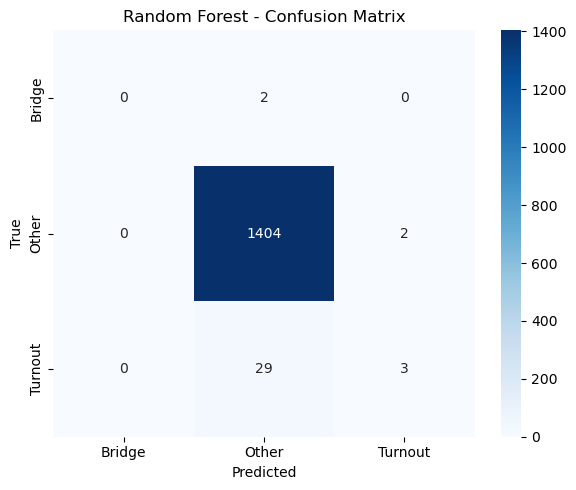

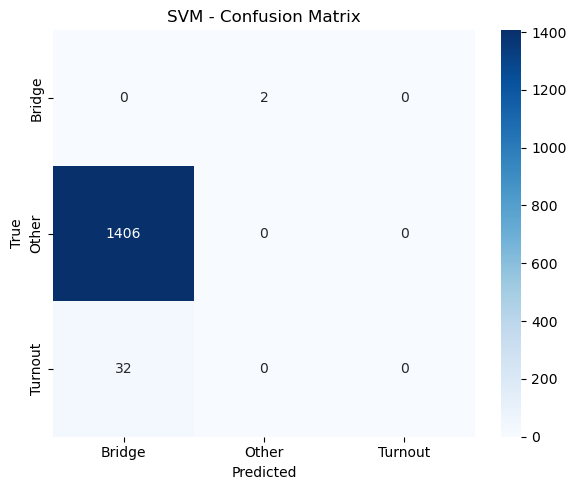

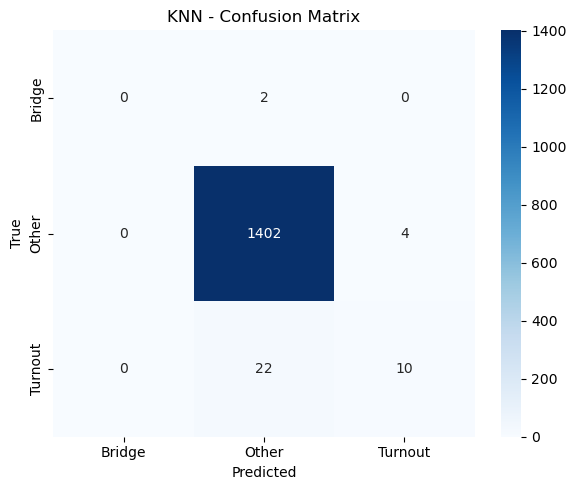

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Manually reconstruct confusion matrices from screenshots:

# Model: Random Forest
cm_rf = np.array([
    [0, 2, 0],
    [0, 1404, 2],
    [0, 29, 3]
])

# Model: SVM
cm_svm = np.array([
    [0, 2, 0],
    [1406, 0, 0],
    [32, 0, 0]
])

# Model: KNN
cm_knn = np.array([
    [0, 2, 0],
    [0, 1402, 4],
    [0, 22, 10]
])

labels = ["Bridge", "Other", "Turnout"]

def plot_cm(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

plot_cm(cm_rf, "Random Forest - Confusion Matrix")
plt.show()

plot_cm(cm_svm, "SVM - Confusion Matrix")
plt.show()

plot_cm(cm_knn, "KNN - Confusion Matrix")
plt.show()


2025-07-29 10:04:13.566709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30


/opt/miniconda3/envs/tf-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9585 - loss: 0.3313 - val_accuracy: 0.9764 - val_loss: 0.1380
Epoch 2/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9840 - loss: 0.0938 - val_accuracy: 0.9764 - val_loss: 0.1188
Epoch 3/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0821 - val_accuracy: 0.9764 - val_loss: 0.1124
Epoch 4/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9840 - loss: 0.0870 - val_accuracy: 0.9764 - val_loss: 0.1105
Epoch 5/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9837 - loss: 0.0833 - val_accuracy: 0.9764 - val_loss: 0.1173
Epoch 6/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9852 - loss: 0.0763 - val_accuracy: 0.9764 - val_loss: 0.1075
Epoch 7/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9784 - loss: 0.1018 - val_accuracy: 0.9764 - val_loss: 0.1146
Epoch 8/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9846 - loss: 0.0786 - val_accuracy: 0.9764 - val_

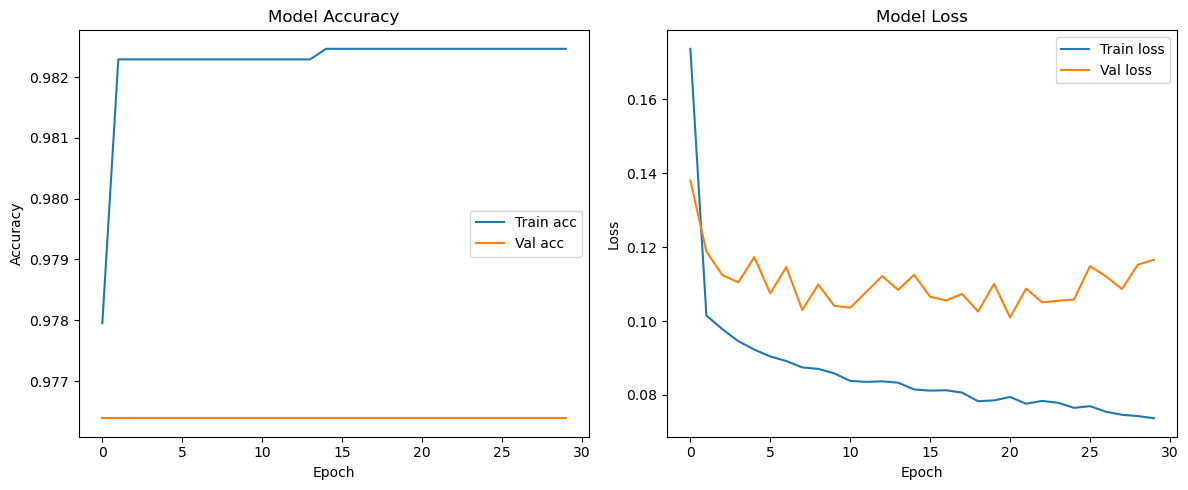

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# ============================
# Load data
# ============================
df = pd.read_csv("features_extracted.csv")

# Encode labels
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])
label_names = le.classes_

X = df.drop(columns=["segment_id", "label", "label_encoded"])
y = df["label_encoded"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode labels
y_cat = to_categorical(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=42)

# ============================
# Build model
# ============================
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ============================
# Train model
# ============================
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

# ============================
# Evaluate model
# ============================
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Final Accuracy on Test Set: {acc:.4f}")

# ============================
# Plot Accuracy & Loss
# ============================
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("deep_learning_training.png")
plt.show()
